In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams

from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC
from Utilities.AncillaryFunctions import compute_snr, GenConArangeSimple, scale_and_normalize

from Models.Caller import *
from Benchmarks.Models.BenchmarkCaller import ModelCall as BMCaller

from Benchmarks.Models.DiffWave import DiffWAVE_Restoration, determine_gen_steps_diffwave
from Benchmarks.Models.VDiffWave import VDiffWAVE_Restoration, determine_gen_steps_vdwave

In [3]:
def CustomLinspace(start, end, breakpoints, numbers):
    """
    Generate a series of points within specified intervals and number of points.

    Parameters:
    start (float): The starting value of the sequence.
    end (float): The end value of the sequence.
    breakpoints (list): A list of points where the intervals change.
    numbers (list): A list of integers indicating the number of points in each interval.

    Returns:
    np.array: An array of points including the start, end, and the specified number of points in each interval.
    """

    # Validate input: there should be one more number than there are breakpoints
    if len(breakpoints) + 1 != len(numbers):
        raise ValueError("There must be one more element in 'numbers' than there are in 'breakpoints'.")

    # Combine the start, breakpoints, and end into a single list of points
    points = [start] + breakpoints + [end]
    
    # Initialize an empty array to hold the result
    result = np.array([])

    # Generate points for each interval
    for i in range(len(numbers)):
        # Determine if the endpoint should be included
        endpoint = True if i == len(numbers) - 1 else False  # Include endpoint only for the last interval
        
        # Generate 'numbers[i]' points between 'points[i]' and 'points[i + 1]'
        part = np.linspace(points[i], points[i + 1], numbers[i], endpoint=endpoint)
        result = np.concatenate((result, part))  # Append the new points to the result

    return result


def SigGen (ConfigName, YamlPath, SelIDX= 1, N_Gen = 300, MinFreqR=0.0, MaxFreqR=0.05, GenBP=None, N_GenList = None):
    
    if N_GenList is not None:
            N_Gen = np.sum(N_GenList)
        
        
    EvalConfigs = ReadYaml(YamlPath)
    
    # Loading the model configurations
    if 'SKZFC' in ConfigName:
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)
        # Loading parameters for the evaluation
        Params = LoadParams(ModelConfigSet, EvalConfigs['Parameters'])
        Params['Common_Info'] = EvalConfigs['Common_Info']
        
        # Loading data
        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')

    elif 'VAE' in ConfigName:
        
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, TypeDesig = True, RootDirYaml='./Benchmarks/Config/')
        # Loading parameters for the evaluation
        CommonParams = EvalConfigs['Common_Param']
        ModelParams = EvalConfigs["Models"][ConfigName]
        Params = LoadParams(ModelConfigSet, {**CommonParams, **ModelParams})
        Params['Common_Info'] = EvalConfigs['Common_Info']
    
        # Loading data
        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')

    elif 'DiffWave' in ConfigName or 'VDWave' in ConfigName:
        ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName, Comp=False, TypeDesig = True, RootDirYaml='./Benchmarks/Config/')
        # Loading parameters for the evaluation
        CommonParams = EvalConfigs['Common_Param']
        ModelParams = EvalConfigs["Models"][ConfigName]
        Params = LoadParams(ModelConfigSet, {**CommonParams, **ModelParams})
        Params['Common_Info'] = EvalConfigs['Common_Info']

        TrData = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'Tr'+str(Params['SigType'])+'.npy').astype('float32')
        VallData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')
        SigMax = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMax.pkl', allow_pickle=True)
        SigMin = np.load('./Data/ProcessedData/'+str(Params['DataSource'])+'SigMin.pkl', allow_pickle=True)
        
        TrDeNorm = (TrData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
        ValDeNorm = (VallData * (SigMax[Params['SigType']] - SigMin[Params['SigType']]) + SigMin[Params['SigType']]).copy()
        
        MeanSig, SigmaSig = np.mean(TrDeNorm), np.std(TrDeNorm) 
        TrInp = (TrDeNorm-MeanSig)/SigmaSig
        ValInp = (ValDeNorm-MeanSig)/SigmaSig

    
    # Intermediate parameters 
    SigDim = VallData.shape[1]
    DataSize = VallData.shape[0]
    Params['DataSize'] = Params['EvalDataSize']


    if 'SKZFC' in ConfigName :

        # Calling Modesl
        SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)
        
        # Setting Model Specifications and Sub-models
        if Params['LossType'] =='Default':
            EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
        elif Params['LossType'] =='FACLosses':
            EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts
    
        NeachFC = len(FeatExtModel.output)
        NCommonFC = EncModel.output[1].shape[1] - NeachFC

        if N_GenList is not None:
            FC_Each = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,NeachFC))
            if NCommonFC==0:
                FC_Comm = np.empty((FC_Each.shape[0],0))
            else:
                FC_Comm = np.tile(CustomLinspace(MinFreqR, MaxFreqR, GenBP, N_GenList)[:, None], (1,NCommonFC))    
        else:
            FC_Each = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,NeachFC))
            if NCommonFC==0:
                FC_Comm = np.empty((FC_Each.shape[0],0))
            else:
                FC_Comm = np.tile(np.linspace(MinFreqR, MaxFreqR, N_Gen )[:, None], (1,NCommonFC))

        
        ## The generation model for evaluation
        RecOut = ReconModel(FeatGenModel.output)
        GenModel = Model(FeatGenModel.input, RecOut)
        
        ## The sampling model for evaluation
        Zs_Out = SigRepModel.get_layer('Zs').output
        SampModel = Model(EncModel.input, Zs_Out)
    
        # Signal generation
        AnalData = VallData
        OrginalSig = AnalData[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampModel.predict(InpSignal)

        FeatGen = FeatGenModel([FC_Comm,FC_Each, PredZs])
        ReconSignal = ReconModel.predict([FeatGen])
        CON_Arange = None
        
    
    elif 'VAE' in ConfigName:
    
        # Calling Modesl
        BenchModel, _, AnalData = BMCaller (Params, ConfigName, TrData, VallData, LoadWeight=True, Reparam=False, ReparaStd=Params['ReparaStd'], ModelSaveName='./Benchmarks/' + ModelLoadName[2:])

        ## The generation model for evaluation
        GenModel = BenchModel.get_layer('ReconModel')

        ## The sampling model for evaluation
        Inp_Enc = BenchModel.get_layer('Inp_Enc')
        
        if 'VDV' in ConfigName:
            Zs = tf.concat([BenchModel.get_layer('Zs'+str(i)).output for i in range(len(Params['LatDim']))], axis=-1)
        else:
            Zs = BenchModel.get_layer('Zs').output
            
        Inp_Cond = BenchModel.get_layer('Inp_Cond')
        SampZModel = Model([Inp_Enc.input, Inp_Cond.input], Zs)

        # Signal generation
        RawSignal, ConData = AnalData
        CON_Arange = GenConArangeSimple(ConData, N_Gen)
        OrginalSig = RawSignal[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)
        PredZs = SampZModel.predict([InpSignal, CON_Arange])
        ReconSignal = GenModel.predict([PredZs, CON_Arange])
    
    
    elif 'DiffWave' in ConfigName or 'VDWave' in ConfigName:
        
        # Calling Modesl
        GenModel, _, AnalData = BMCaller (Params, ConfigName, TrInp, ValInp, LoadWeight = True, ModelSaveName='./Benchmarks/' + ModelLoadName[2:])  

        RawSignal, ConData = AnalData
        CON_Arange = GenConArangeSimple(ConData, N_Gen)

        OrginalSig = RawSignal[SelIDX:SelIDX+1]
        InpSignal = np.repeat(OrginalSig, N_Gen, axis=0)

        if 'DiffWave' in ConfigName:
            # Perform diffusion with determined steps and restore the signal
            GenSteps, noise = determine_gen_steps_diffwave(InpSignal, GenModel, Params['Iter'], Params['GaussSigma'], Params['SNR_cutoff'])
            diffused, _ = GenModel.diffusion(InpSignal, GenModel.alpha_bar[GenSteps].item(), noise)
            GenSig = DiffWAVE_Restoration(GenModel, diffused, CON_Arange,  GenBatchSize=1000, GenSteps=GenSteps, StepInterval=Params['StepInterval'])
        elif 'VDWave' in ConfigName:
            GenSteps, t_float, noise = determine_gen_steps_vdwave(InpSignal, GenModel, Params['Iter'], Params['SNR_cutoff'])
            diffused, _, noise = GenModel.sample_q_t_0(InpSignal, t_float, None, gamma_t=None)
            GenSig = VDiffWAVE_Restoration(GenModel, diffused[0][..., None], CON_Arange,  GenSteps, GenModel.cfg['StepInterval'], GenBatchSize=Params['GenBatchSize'])            
       
        # Scale and normalize the restored signal and ground truth
        ReconSignal = scale_and_normalize(np.squeeze(GenSig), SigmaSig, MeanSig, SigMin[Params['SigType']], SigMax[Params['SigType']])
        OrginalSig = scale_and_normalize(OrginalSig, SigmaSig, MeanSig, SigMin[Params['SigType']], SigMax[Params['SigType']])
        PredZs = None

    HalfLen = ReconSignal.shape[1]//2
    FFTRes = np.abs(np.fft.fft(ReconSignal, axis=-1)[:, :HalfLen]) 
    Amplitude = FFTRes/HalfLen

    return ReconSignal, Amplitude, OrginalSig, PredZs, CON_Arange
    

In [4]:
DicConfigYaml = { 
    'ART_VitalDB' : {'SKZFC_ART_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_ART_VitalDB':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_VitalDB':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
   
    'ART_Mimic' : {'SKZFC_ART_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_ART_Mimic':   './Benchmarks/Config/EvalConfigART_Other.yml', 
                     'VDVAE_ART_30_Mimic':   './Benchmarks/Config/EvalConfigART_VAE.yml'},
    
    'II_VitalDB' : {'SKZFC_II_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                     'VDWave_II_VitalDB':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_VitalDB':   './Benchmarks/Config/EvalConfigII_VAE.yml'},
    
    'II_Mimic' : {'SKZFC_II_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     'VDWave_II_Mimic':   './Benchmarks/Config/EvalConfigII_Other.yml', 
                     'VDVAE_II_30_Mimic':   './Benchmarks/Config/EvalConfigII_VAE.yml'}    }

'''
DicConfigYaml = { 
    'ART_VitalDB' : {'SKZFC_ART_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
},
   
    'ART_Mimic' : {'SKZFC_ART_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                     },
    
    'II_VitalDB' : {'SKZFC_II_1_30_800_VitalDB':   './Config/EvalConfigVitalDB.yml',              
                    },
    
    'II_Mimic' : {'SKZFC_II_1_30_800_Mimic':   './Config/EvalConfigMimic.yml',              
                    }    }

'''


MinFreq=1
MaxFreq=50

DicParam = {'ART_VitalDB': 
                         {'SelIDX' : 13, 
                          'MinFreqR':0.0015, 
                          'MaxFreqR':0.9, 
                          'GenBP':[0.02, 0.1],
                          'N_GenList':[500, 50, 50] },
            'ART_Mimic': 
                         {'SelIDX' : 13, 
                          'MinFreqR':0.008, 
                          'MaxFreqR':0.9, 
                          'GenBP':[0.02, 0.1], 
                          'N_GenList':[500, 50, 50] },
            'II_VitalDB': 
                         {'SelIDX' : 30, 
                          'MinFreqR':0.01, 
                          'MaxFreqR':0.7, 
                          'GenBP':[0.1, 0.5], 
                          'N_GenList':[500, 50, 50] },
            'II_Mimic': 
                         {'SelIDX' : 1, 
                          'MinFreqR':0.001, 
                          'MaxFreqR':0.99, 
                          'GenBP':[0.05, 0.1], 
                          'N_GenList':[500, 50, 50] }
           }





GeneratedSignals = {}
GeneratedAmplitude = {}
InpSignals = {}
Zs = {}
CON_Aranges = {}

GeneratedSignals = {}
GeneratedAmplitude = {}
InpSignals = {}
Zs = {}
CON_Aranges = {}

for ConfigYaml in DicConfigYaml.items():
    SelIDX, MinFreqR, MaxFreqR,GenBP, N_GenList = DicParam[ConfigYaml[0]].values()
    for ConfigName in ConfigYaml[1]:
        print(ConfigName)
        ReconSignal, Amplitude, InpSignal, PredZs, CON_Arange = SigGen(ConfigName, ConfigYaml[1][ConfigName], SelIDX= SelIDX, 
                                                                       N_Gen = np.sum(N_GenList), MinFreqR=MinFreqR, MaxFreqR=MaxFreqR,  GenBP=GenBP, N_GenList=N_GenList) #56
        GeneratedSignals[ConfigName] = ReconSignal
        GeneratedAmplitude[ConfigName] = Amplitude
        InpSignals[ConfigName] = InpSignal
        Zs[ConfigName] = PredZs
        CON_Aranges[ConfigName] = CON_Arange

SKZFC_ART_1_30_800_VitalDB
OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 50)      11550       ['bidirecti

[Restoration] Processing Steps: 100%|█████████████████████████████████| 36/36 [00:02<00:00, 15.38it/s, Current Step=71]


VDVAE_ART_30_VitalDB
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_3 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_3[0][0]']      
 l)                                                                                               
                                                                                                  
 bidirectional_15 (Bidirectiona  (None, 20, 50)      11550       ['bidi

[Restoration] Processing Steps: 100%|█████████████████████████████████| 36/36 [00:01<00:00, 20.55it/s, Current Step=71]


VDVAE_ART_30_Mimic
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_7 (TFOpLambda)  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional_46 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_7[0][0]']      
 l)                                                                                               
                                                                                                  
 bidirectional_47 (Bidirectiona  (None, 20, 50)      11550       ['bidire

[Restoration] Processing Steps: 100%|█████████████████████████████████| 42/42 [00:02<00:00, 20.38it/s, Current Step=83]


VDVAE_II_30_VitalDB
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_11 (TFOpLambda  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_78 (Bidirectiona  (None, 20, 50)      11550       ['tf.signal.frame_11[0][0]']     
 l)                                                                                               
                                                                       

[Restoration] Processing Steps: 100%|█████████████████████████████████| 42/42 [00:02<00:00, 20.04it/s, Current Step=83]


VDVAE_II_30_Mimic
Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame_15 (TFOpLambda  (None, 20, 50)      0           ['Inp_Enc[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_110 (Bidirection  (None, 20, 50)      11550       ['tf.signal.frame_15[0][0]']     
 al)                                                                                              
                                                                         

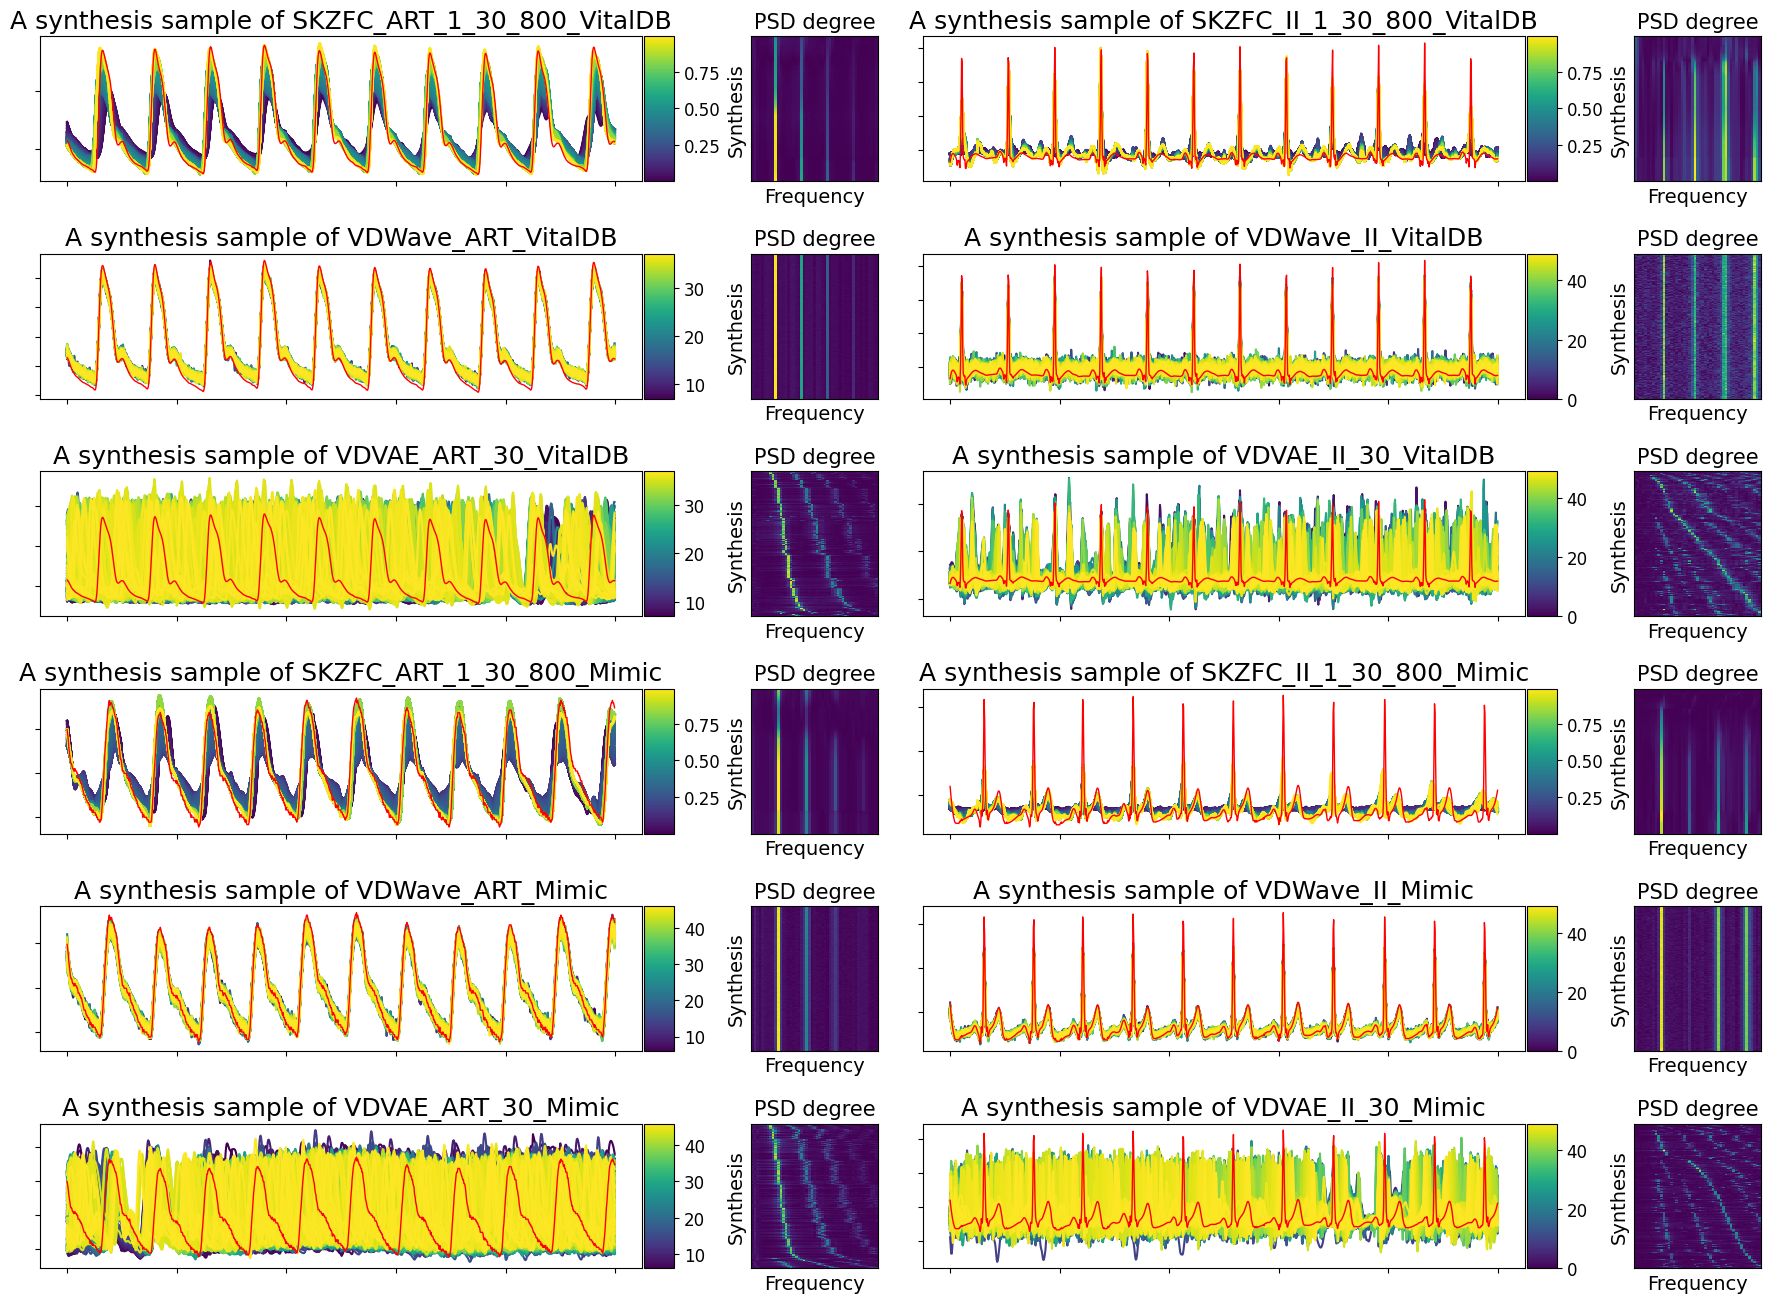

In [6]:
N_Gen = sum(DicParam['ART_VitalDB']['N_GenList'])

# Define the keys for the data you want to plot.
keys = [ConfigName[0] for ConfigItems in DicConfigYaml.items() for ConfigName in ConfigItems[1].items()]

# Set up colormap and normalization.
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, N_Gen-1)

# Create a figure with GridSpec layout for a 3x2 grid of line plots and heatmaps.
fig = plt.figure(figsize=(22, 16))
gs = GridSpec(6, 4, figure=fig, width_ratios=[5, 1, 5, 1], hspace=0.5, wspace=0.16)  # Allocate space for color bars

row_idx = -1
col_idx_line = 0
col_idx_heat = 1

# Iterate over the keys and create the corresponding subplots for line plots and heatmaps.
for idx, key in enumerate(keys):
    # Calculate row index for the current subplot.
    row_idx += 1
    col_idx_heat = col_idx_line+1

    if 'SKZFC' in key :
        norm2 = plt.Normalize(MinFreqR, MaxFreqR)
        cbarLabel = '$\\acute{\\theta}$ for generation'
    
    elif 'VAE' in key or 'DiffWave' in key or 'VDWave' in key:
        FreqIDX = np.argmax(CON_Aranges[key], axis=-1)
        norm2 = plt.Normalize(np.min(FreqIDX), np.max(FreqIDX))
        cbarLabel = '$\\acute{\\theta}$ for generation'
    
    # Create the axis for the line plot.
    ax1 = fig.add_subplot(gs[row_idx, col_idx_line])
    for i in range(0, N_Gen):
        color = cmap(norm(i))
        ax1.plot(GeneratedSignals[key][i], color=color)
    ax1.plot(InpSignals[key][0], color='red', label='Input Signal',linewidth=1)        

    
    if 'ART' in key:
        SigType = 'ABP'
    elif 'II' in key:
        SigType = 'ECG'
    
    if 'SKZFC' in key:
        Label = 'SKZFC'
    elif 'ConVAE' in key:
        Label = '$C$-VAE'
    elif 'TCVAE' in key:
        Label = '$TC$-VAE'
    elif 'FACVAE' in key:
        Label = '$FAC$-VAE'
    elif 'DiffWave' in key:
        Label = 'DiffWave'
    elif 'VDWave' in key:
        Label = 'VDWave'
     
    
    ax1.set_title('A synthesis sample of '+ key, fontsize=18)

    ax1.set_xticklabels([])  # Hide x-axis tick labels
    ax1.set_yticklabels([])  # Hide y-axis tick labels   
    # Create an axis for the color bar on the right side of the line plot.
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.02)
    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm2)
    sm1.set_array([])
    cbar1=fig.colorbar(sm1, cax=cax1)
    cbar1.ax.tick_params(labelsize=12)
    #cbar1.set_label(cbarLabel, size=12)

    # Create the axis for the heatmap next to each line plot.
    ax2 = fig.add_subplot(gs[row_idx, col_idx_heat])
    Heatmap = GeneratedAmplitude[key][:, MinFreq:MaxFreq]
    im = ax2.imshow(Heatmap, cmap='viridis', aspect='auto', interpolation='nearest')
    ax2.set_title('PSD degree', fontsize=15)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_ylabel('Synthesis', fontsize=14) #'Index of signals generated with a series of $\\acute{\\theta}$'
    
    if row_idx == 5:
        row_idx = -1
        col_idx_line = 2

    pos1 = ax1.get_position()  # get the original position
    pos2 = ax2.get_position()  # get the original position
    ax1.set_position([pos1.x0, pos1.y0, pos1.width, pos1.height])
    ax2.set_position([pos1.x0 + pos1.width + 0.035, pos2.y0, pos2.width, pos2.height])  # Adjust th e x position
    #print(row_idx, col_idx_line)

plt.show()